In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import json

In [2]:
## Global Params
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 18  # Adjust the font size
colors = ['#a8ddb5', '#7bccc4', '#43a2ca','#0868ac']

## Global Params


def read_text_files(directory,component,number,label):
    text_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                d={
                'In-Flight':0,
                'Throughput':0,
                'Latency(ms)': 0,
                'ScaleFactor': component,
                "# of Components":number,
                "Label":label
                }
                for line in file:
                    if line.startswith("In-Flight Requests"):
                        inFlight = int(line.split(' ')[2].strip())
                        d['In-Flight']=inFlight
                    if line.startswith("Ops/s"):
                        parts = line.split(',')
                        throughput = int(parts[1])
                        d['Throughput']=throughput/30
                    
                    if line.startswith("Average Latency"):
                        latency = int(line.split(' ')[2])
                        d['Latency(ms)']=latency
                
                text_data.append(d)
    return text_data



def read_json_files_to_df(directory,label):
    throughput_data = []
    experiment_number = 1
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                throughput = data.get('Goodput (requests/second)', None)
                latency = data.get('Latency Distribution', None).get('Average Latency (microseconds)',None)
                if latency is not None:
                    latency = latency/1000
                if throughput is not None and latency is not None:
                    throughput_data.append({'Experiment': f'Experiment {experiment_number}', 'Throughput': throughput, "Latency(ms)":latency, "Label":label})
                    experiment_number += 1
    return pd.DataFrame(throughput_data)

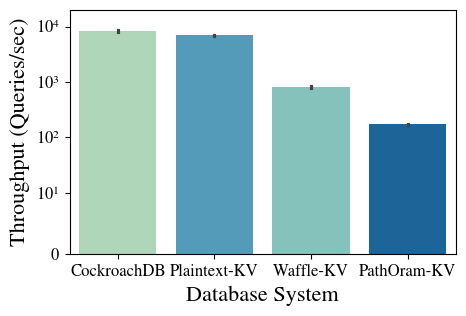

In [3]:
#Read CockroachDB
directory = "/home/haseeb/Desktop/ReviewGraphs/PlaintextBaseline/CockroachDB"
mySQLDF = read_json_files_to_df(directory,"CockroachDB")


#Read Waffle Encrypt Baseline
baselineScaleOne = '/home/haseeb/Desktop/ReviewGraphs/PlaintextBaseline/Waffle'

#Read Oram Encrypt Baseline
oramScaleOne = '/home/haseeb/Desktop/ReviewGraphs/PlaintextBaseline/ORAM'

#Read Plaintext baseline
plaintextDefault = '/home/haseeb/Desktop/ReviewGraphs/PlaintextBaseline/Plaintext'

## Read and Make into DF
readORAMBaseLine = read_text_files(oramScaleOne, '1', 3, "PathOram-KV")
readWaffleBaseLine = read_text_files(baselineScaleOne, '1', 3, "Waffle-KV")
readPTBaseLine = read_text_files(plaintextDefault, '1', 3, "Plaintext-KV")

baseLinePTDF = pd.DataFrame(readPTBaseLine)
baseLineWaffleDF = pd.DataFrame(readWaffleBaseLine)
baseLineORAMDF = pd.DataFrame(readORAMBaseLine)

#Make DF
newDf = pd.concat([mySQLDF,baseLineWaffleDF,baseLinePTDF,baseLineORAMDF])
## Read and Make into DF

#Plotting

displayOrder = ['CockroachDB',"Plaintext-KV","Waffle-KV","PathOram-KV"]
fig, ax = plt.subplots(figsize=(5, 3.5)) 

# Create bar plot
ax = sns.barplot(data=newDf, x='Label', y='Throughput',hue='Label',legend=False, palette=colors, order=displayOrder)

# Labels and title
ax.set_xlabel("Database System", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_yscale("symlog", linthresh=10) 
ax.set_ylim(top=20000)

ax.tick_params(axis='both', which='major', labelsize=12)


fig = ax.get_figure()
fig.tight_layout()
fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/PlaintextBaseline.png", format="png", bbox_inches="tight")

plt.show()

In [4]:
newDf
grouped_df = newDf.groupby('Label')[['Throughput', 'Latency(ms)']].mean()
print(grouped_df)

               Throughput  Latency(ms)
Label                                 
CockroachDB   8425.470509   137.999000
PathOram-KV    173.500000   845.333333
Plaintext-KV  6961.144444   141.333333
Waffle-KV      820.022222   891.666667
